In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
import xarray as xr
import math
import time
from skimage.morphology import binary_erosion
import matplotlib.colors as mcolors
from matplotlib import cm
from collections import deque
#from APF_netcdf import APF
import APF_sakai_netcdf as APF
import geopy.distance
show_animation = False

In [79]:
k_att, k_rep = 0.1, 8000
rr = 15  # obstacle dimension - range of influence
n = 1  # number of obstacles
d_o_lim = 5

# a_g = 100  # max attractive pot
# b_g = 10   # width of the distribution

x_max = 100
y_max = 80
x = np.arange(0, x_max, 1)
y = np.arange(0, y_max, 1)
X, Y = np.meshgrid(x, y)

start = (0, 0)
goal = (50, 40)
obs = [[0,0]]#[10, 40], [35, 65], [45, 70], [55, 68], [62, 60], [63, 50], [62, 42], [53, 35]]  # atoll scenario
# obs = [[1, 4], [2, 4], [3, 3], [6, 1], [6, 7], [10, 6], [11, 12], [14, 14]]
# obs = [[random.uniform(0, goal[1]), random.uniform(0, goal[1])] for i in range(n)]
# obs = [[60, 60], [20, 20], [10, 10], [30, 10], [10, 30], [80, 80], [60, 70]]
# obs = [[85, 85]]  # GNRON scenario
print('There are {} obstacles: {}'.format(n, obs))
q_g = 20

def comb_attractive_potential(x, y, goal, quad_range, k_att):
    d_g = np.sqrt((x - goal[0]) ** 2 + (y - goal[1]) ** 2)
    if d_g <= 1:
        d_g = 1
    if d_g <= quad_range:
        u_att = 0.5 * k_att * d_g ** 2
    else:
        u_att = q_g * k_att * d_g - 0.5 * k_att * q_g ** 2
    return u_att

def quad_attractive_potential(x, y, goal, k_att):
    d_g = np.sqrt((x - goal[0]) ** 2 + (y - goal[1]) ** 2)
    if d_g <= 1:
        d_g = 1
    u_att = 0.5 * k_att * d_g**2
    return u_att

def conic_attractive_potential(x, y, goal, k_att):
    d_g = np.sqrt((x - goal[0]) ** 2 + (y - goal[1]) ** 2)
    if d_g <= 0.1:
        d_g = 0.1
    u_att = k_att * d_g
    return u_att

# def repulsive_potential(x, y, obstacle, d_o_lim, rr, k):
#     d_o = np.sqrt((x - obstacle[k][0]) ** 2 + (y - obstacle[k][1]) ** 2)
#     if d_o < d_o_lim:
#         d_o = d_o_lim
#     if d_o <= rr:
#         u_rep = 0.5 * k_rep * (1 / d_o - 1 / rr) ** 2
#     else:
#         u_rep = 0
#     return u_rep

There are 1 obstacles: [[0, 0]]


In [80]:
pot_map = [[0.0 for i in range(y_max)] for j in range(x_max)]
pot_map2 = np.zeros_like(pot_map)
pot_map3 = np.zeros_like(pot_map)
for i in range(x_max):
    for j in range(y_max):
        u_att1 = comb_attractive_potential(i, j, goal, q_g, k_att)
        u_att2 = quad_attractive_potential(i, j, goal, k_att)
        u_att3 = conic_attractive_potential(i, j, goal, k_att)
        pot_map[i][j] = u_att1
        pot_map2[i][j] += u_att2
        pot_map3[i][j] += u_att3
#         for k in range(n):
            # e_xo = 1/d_o * (i - obs[k][0])
            # e_yo = 1/d_o * (j - obs[k][1])
            # delta_X[i][j] += e_xo * k_rep * (1 / d_o[i][j] - 1 / rr) / (d_o[i][j] ** 2)
            # delta_Y[i][j] += e_yo * k_rep * (1 / d_o[i][j] - 1 / rr) / (d_o[i][j] ** 2)
#             u_rep = repulsive_potential(i, j, obs, d_o_lim, rr, k)
# #             pot_map[i][j] += u_rep
#             pot_map2[i][j] += u_rep
#             pot_map3[i][j] += u_rep

plot_map = np.array(pot_map)
plot_map2 = np.array(pot_map2)
plot_map3 = np.array(pot_map3)

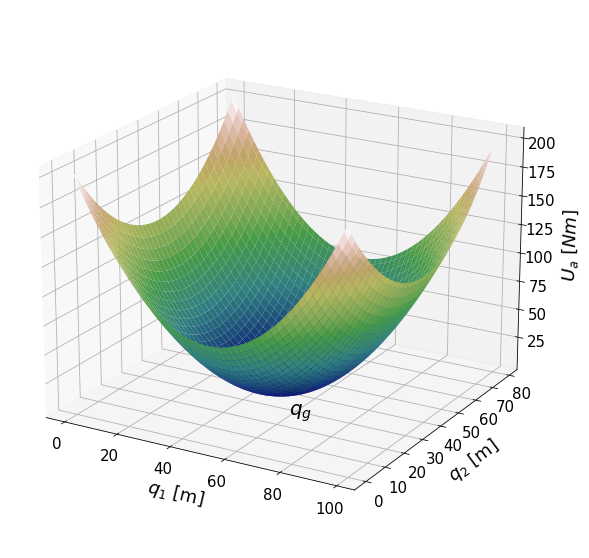

In [120]:
fig2 = plt.figure(1, figsize=(12, 10))
c_map = plt.get_cmap('gist_earth')
ax = fig2.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, plot_map2.T, cmap=c_map)
ax.set_xlabel("$q_1$ [m]", fontsize=18)
ax.set_ylabel("$q_2$ [m]", fontsize=18)
ax.set_zlabel("$U_a$ [$Nm$]", fontsize=18)
ax.yaxis.labelpad=10
ax.xaxis.labelpad=10
ax.zaxis.labelpad=10

ax.tick_params(labelsize=15)
ax.text(goal[0], goal[1], -25, "$q_g$", color='k', fontsize=20)
# ax.set_zticks([])
# ax.title.set_text('Potential field algorithm')
# ax.contourf(X, Y, plot_map2.T, zdir='z', offset=0)
ax.view_init(20, -60)
# c_bar = fig2.colorbar(surf)
# c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.savefig("potential1.png", dpi=300, bbox_inches='tight')
plt.show()

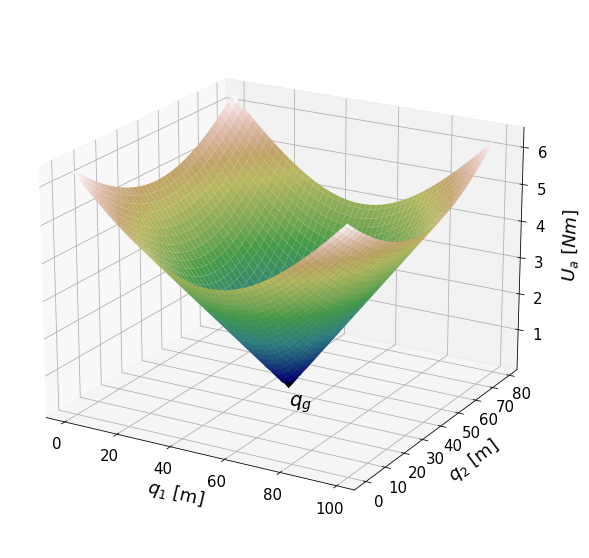

In [122]:
fig2 = plt.figure(1, figsize=(12, 10))
c_map = plt.get_cmap('gist_earth')
ax = fig2.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, plot_map3.T, cmap=c_map)
ax.set_xlabel("$q_1$ [m]", fontsize=18)
ax.set_ylabel("$q_2$ [m]", fontsize=18)
ax.set_zlabel("$U_a$ [$Nm$]", fontsize=18)
ax.yaxis.labelpad=10
ax.xaxis.labelpad=10
ax.zaxis.labelpad=10

ax.tick_params(labelsize=15)
ax.text(goal[0], goal[1], -0.5, "$q_g$", color='k', fontsize=20)
# ax.title.set_text('Potential field algorithm')
# ax.contourf(X, Y, plot_map2.T, zdir='z', offset=0)
ax.view_init(20, -60)
# c_bar = fig2.colorbar(surf)
# c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.savefig("potential2.png", dpi=300, bbox_inches='tight')
plt.show()

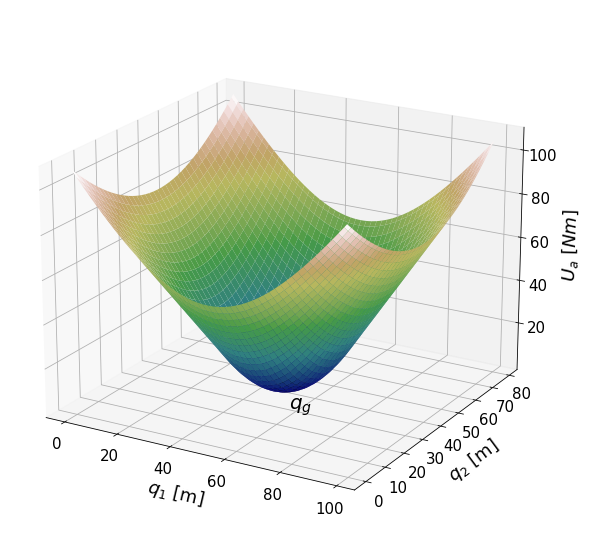

In [123]:
fig2 = plt.figure(1, figsize=(12, 10))
c_map = plt.get_cmap('gist_earth')
ax = fig2.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, plot_map.T, cmap=c_map)
ax.set_xlabel("$q_1$ [m]", fontsize=18)
ax.set_ylabel("$q_2$ [m]", fontsize=18)
ax.set_zlabel("$U_a$ [$Nm$]", fontsize=18)
ax.yaxis.labelpad=10
ax.xaxis.labelpad=10
ax.zaxis.labelpad=10

ax.tick_params(labelsize=15)
ax.text(goal[0], goal[1], -10, "$q_g$", color='k', fontsize=20)
# ax.title.set_text('Potential field algorithm')
# ax.contourf(X, Y, plot_map2.T, zdir='z', offset=0)
ax.view_init(20, -60)
# c_bar = fig2.colorbar(surf)
# c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.savefig("potential3.png", dpi=300, bbox_inches='tight')
plt.show()

In [38]:
data = xr.open_dataset('med-hcmr-wav-an-fc-h_1637573239403.nc')  # wave height 22 november
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
time = data.variables['time'][:]
wave = data.variables['VHM0'][:]
mask = data_stat.variables['mask'][0,:,:]
print(data)
print("------------------------------------------------------")
print(mask)

<xarray.Dataset>
Dimensions:    (latitude: 380, time: 24, longitude: 1307)
Coordinates:
  * latitude   (latitude) float32 30.19 30.23 30.27 30.31 ... 45.9 45.94 45.98
  * time       (time) datetime64[ns] 2021-11-22 ... 2021-11-22T23:00:00
  * longitude  (longitude) float32 -18.12 -18.08 -18.04 ... 36.21 36.25 36.29
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2021-11-21 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instanta

<ipython-input-39-fe1cccacc5fb>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')


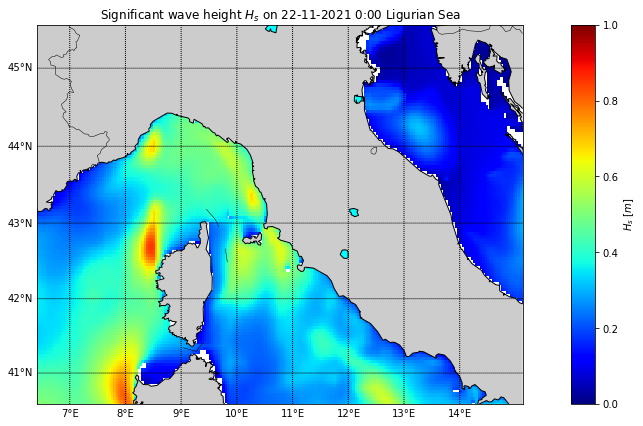

In [39]:
plt.figure(1, figsize=(10, 7))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')
             
lon, lat = np.meshgrid(lons, lats)
x, y = mp(lon, lat)

c_scheme = mp.pcolor(x, y, wave[0], cmap='jet')
#plt.scatter(50000, 0, linewidth=10, marker='o', color='white')
mp.fillcontinents(lake_color='aqua')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes
cbar = mp.colorbar(c_scheme, location='right', pad='10%')
plt.clim(0, 1)
cbar.set_label('$H_s$ $[m]$')

plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

<ipython-input-40-ef3ae3dd9ef7>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, contour_raw_meteo[0], cmap=ListedColormap(['white', 'red']))
<ipython-input-40-ef3ae3dd9ef7>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, contour_raw_meteo[1], cmap=ListedColormap(['white', 'red']))
<ipython-input-40-ef3ae3dd9ef7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 

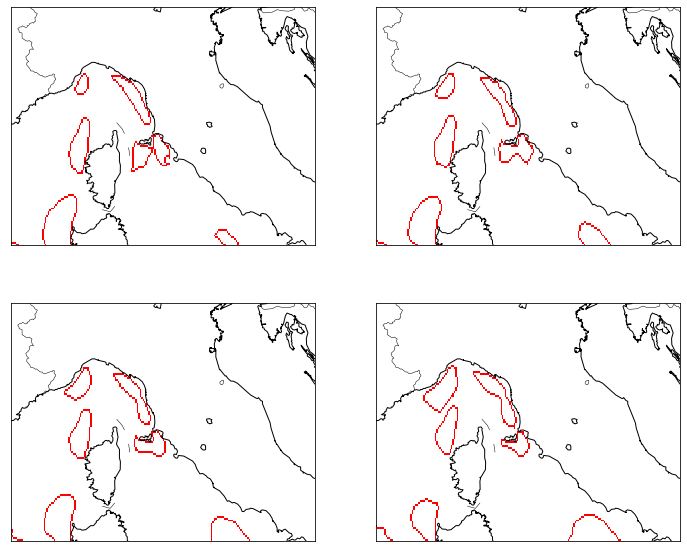

In [40]:
l = 5 
cost = np.zeros_like(wave[:l])
contour_raw_meteo = np.zeros_like(wave[:l])
for i in range(l):
    cost[i] = 100 * (np.array(wave[i]) >0.5) # + 100 * (np.array(data.VHM0[0]) != (np.array(data.VHM0[0])))
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i])) 

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[0][0])
#c_scheme = mp.pcolor(x, y, cost[0], cmap=ListedColormap(['white', 'red']))
mp.pcolor(x, y, contour_raw_meteo[0], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[0][1])
mp.pcolor(x, y, contour_raw_meteo[1], cmap=ListedColormap(['white', 'red']))
#c_scheme1 = mp.pcolor(x, y, cost[1], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][0])

#c_scheme1 = mp.pcolor(x, y, cost[2], cmap=ListedColormap(['white', 'red']))
mp.pcolor(x, y, contour_raw_meteo[2], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][1])
mp.pcolor(x, y, contour_raw_meteo[3], cmap=ListedColormap(['white', 'red']))
#c_scheme1 = mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.show()

# Starting Potential field

In [42]:
x_min, y_min = mp(8.958334, 41.354168)    # lons.values[650], lats.values[268] 
x_max, y_max = mp(11.500001, 43.270832)   # lons.values[711], lats.values[314]
print("The area of movement is:")
print("x_min = {}, y_min = {}\nx_max = {}, y_max = {}".format(x_min, y_min, x_max, y_max))

The area of movement is:
x_min = 282249.730022532, y_min = 114007.03369052801
x_max = 564870.0725610546, y_max = 402247.96147155575


### Obstacle definition

In [43]:
contour_raw_land=np.logical_xor(mask,binary_erosion(mask)) 

Cspacex, Cspacey = [], []   # all configuration space points
oxmeteo, oymeteo = [[] for i in range(l)], [[] for i in range(l)]    # all meteo points
x_obsm, y_obsm = [[] for i in range(l)], [[] for i in range(l)]     # contour meteo points

oxmeteo_, oymeteo_ = [[] for i in range(l)], [[] for i in range(l)]   # all meteo points
x_obsm_, y_obsm_ = [[] for i in range(l)], [[] for i in range(l)]     # contour meteo points


In [47]:
oxland, oyland = [], []
x_obsl, y_obsl = [], []
for i in range(l):
    for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons.values[650] <= lons.values[j] <= lons.values[711] and lats.values[268] <= lats.values[k] <= lats.values[314]:  
                if cost[i][k][j] == 100:
                    oxmeteo[i].append(lons.values[j])
                    oymeteo[i].append(lats.values[k])
                if contour_raw_meteo[i][k][j]:
                    x_obsm[i].append(lons.values[j])
                    y_obsm[i].append(lats.values[k])
    oxmeteo_[i], oymeteo_[i] = mp(oxmeteo[i], oymeteo[i])   # meteo points
    x_obsm_[i], y_obsm_[i] = mp(x_obsm[i], y_obsm[i])       # meteo contour points
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons.values[650] <= lons.values[j] <= lons.values[711] and lats.values[268] <= lats.values[k] <= lats.values[314]:                      
                if contour_raw_land[k][j]: 
                    x_obsl.append(lons.values[j])
                    y_obsl.append(lats.values[k])
                if mask.values[k][j] == 0:
                    oxland.append(lons.values[j])
                    oyland.append(lats.values[k])
                if mask.values[k][j] == 1:
                    Cspacex.append(lons.values[j])
                    Cspacey.append(lats.values[k])

Cspacex_, Cspacey_ = mp(Cspacex, Cspacey)
x_obsl_, y_obsl_ = mp(x_obsl, y_obsl)       # coastline points
oxland_, oyland_ = mp(oxland, oyland)       # land points
# x_obstot_ = x_obsm_ + x_obsl_
# y_obstot_ = y_obsm_ + y_obsl_

### Mapping area of movement and obstacle contours

START is at (334537.5629266633,378168.2533945432), GOAL is at (542631.0977041185,250766.70724292006)


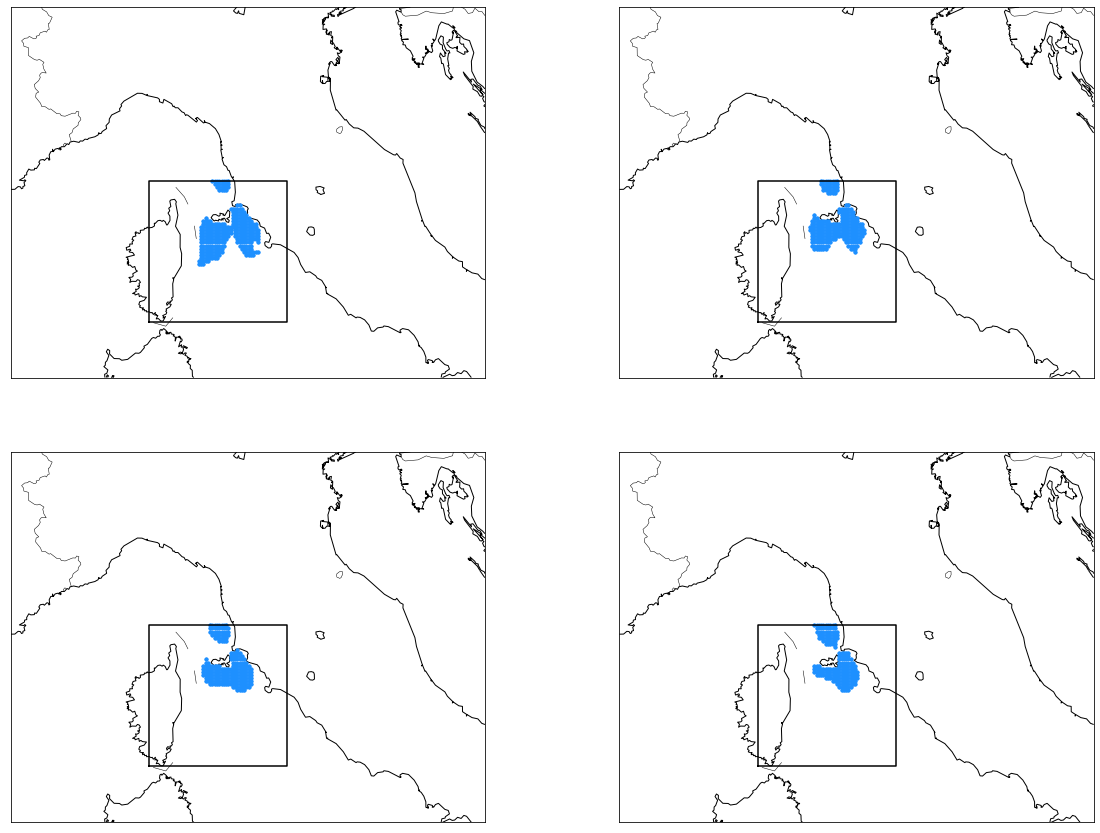

In [49]:
sx, sy = mp(9.42857, 43.11295)
gx, gy = mp(11.300001, 42.270832)
print("START is at ({},{}), GOAL is at ({},{})".format(sx, sy, gx, gy))

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[0][0])
mp.plot(oxmeteo_[0], oymeteo_[0], ".", color="dodgerblue")
mp.plot(x_obsm_[0], y_obsm_[0], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[0][1])
mp.plot(oxmeteo_[1], oymeteo_[1], ".", color="dodgerblue")
mp.plot(x_obsm_[1], y_obsm_[1], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][0])
mp.plot(oxmeteo_[2], oymeteo_[2], ".", color="dodgerblue")
mp.plot(x_obsm_[2], y_obsm_[2], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][1])
mp.plot(oxmeteo_[3], oymeteo_[3], ".", color="dodgerblue")
mp.plot(x_obsm_[3], y_obsm_[3], ".", color="dodgerblue")
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
#plt.savefig('changing_weather.png', dpi=300)
plt.show()

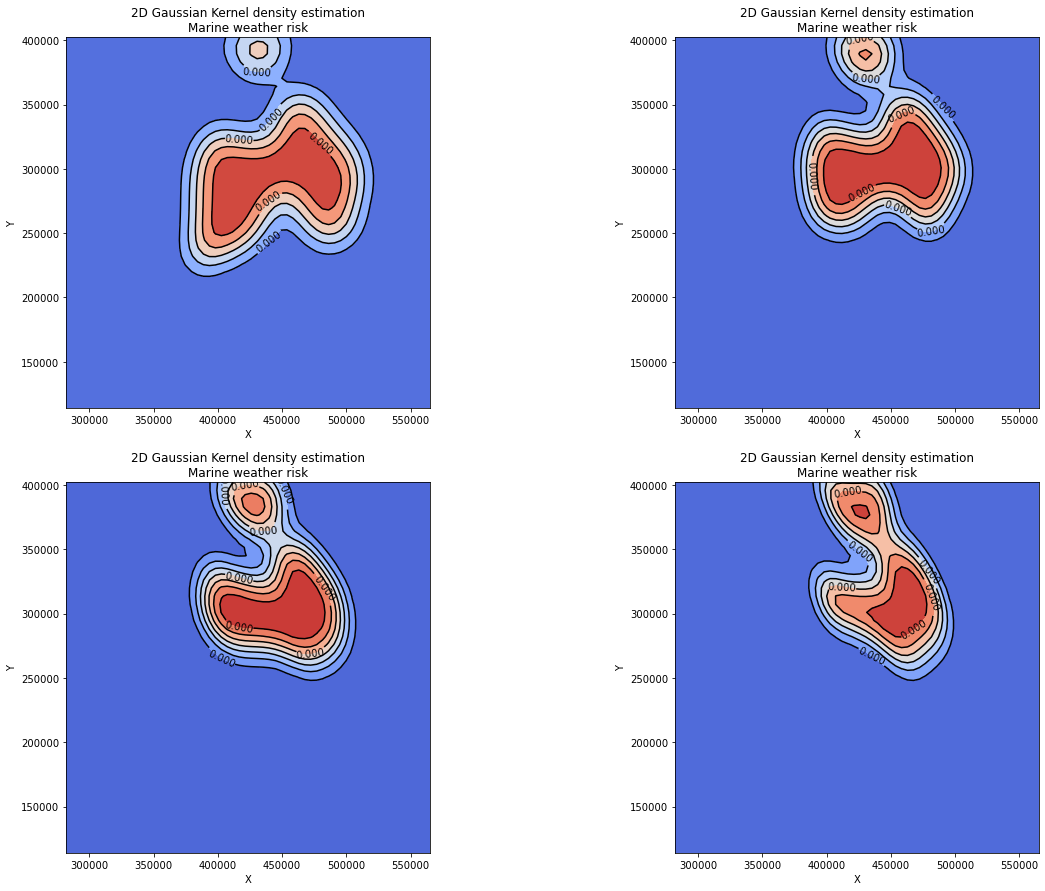

In [50]:
import scipy.stats as st

xslice = lons.values[650:712]
yslice = lats.values[268:315]
xs, ys = np.meshgrid(xslice, yslice)
xs_, ys_ = mp(xs, ys)

positions = np.vstack([xs_.ravel(), ys_.ravel()])
values = np.vstack([oxland_+x_obsl_, oyland_+y_obsl_])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xs_.shape)*3

f2 = [[] for i in range(l)]
for i in range(l):
    positions2 = np.vstack([xs_.ravel(), ys_.ravel()])
    values2 = np.vstack([oxmeteo_[i]+x_obsm_[i], oymeteo_[i]+y_obsm_[i]])
    kernel2 = st.gaussian_kde(values2)
    f2[i] = np.reshape(kernel2(positions2).T, xs_.shape)

f_tot = f2
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
ax[0][0].set_xlim(x_min, x_max)
ax[0][0].set_ylim(y_min, y_max)
cfset = ax[0][0].contourf(xs_, ys_, f_tot[0], cmap='coolwarm')
ax[0][0].imshow(np.rot90(f_tot[0]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[0][0].contour(xs_, ys_, f_tot[0], colors='k')
ax[0][0].clabel(cset, inline=1, fontsize=10)
ax[0][0].set_xlabel('X')
ax[0][0].set_ylabel('Y')
ax[0][0].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')

ax[0][1].set_xlim(x_min, x_max)
ax[0][1].set_ylim(y_min, y_max)
cfset = ax[0][1].contourf(xs_, ys_, f_tot[1], cmap='coolwarm')
ax[0][1].imshow(np.rot90(f_tot[1]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[0][1].contour(xs_, ys_, f_tot[1], colors='k')
ax[0][1].clabel(cset, inline=1, fontsize=10)
ax[0][1].set_xlabel('X')
ax[0][1].set_ylabel('Y')
ax[0][1].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')

ax[1][0].set_xlim(x_min, x_max)
ax[1][0].set_ylim(y_min, y_max)
cfset = ax[1][0].contourf(xs_, ys_, f_tot[2], cmap='coolwarm')
ax[1][0].imshow(np.rot90(f_tot[2]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[1][0].contour(xs_, ys_, f_tot[2], colors='k')
ax[1][0].clabel(cset, inline=1, fontsize=10)
ax[1][0].set_xlabel('X')
ax[1][0].set_ylabel('Y')
ax[1][0].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')

ax[1][1].set_xlim(x_min, x_max)
ax[1][1].set_ylim(y_min, y_max)
cfset = ax[1][1].contourf(xs_, ys_, f_tot[3], cmap='coolwarm')
ax[1][1].imshow(np.rot90(f_tot[3]), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
cset = ax[1][1].contour(xs_, ys_, f_tot[3], colors='k')
ax[1][1].clabel(cset, inline=1, fontsize=10)
ax[1][1].set_xlabel('X')
ax[1][1].set_ylabel('Y')
ax[1][1].set_title('2D Gaussian Kernel density estimation\nMarine weather risk')
plt.savefig('apf_gaussian_meteo.png', dpi=300)
plt.show()

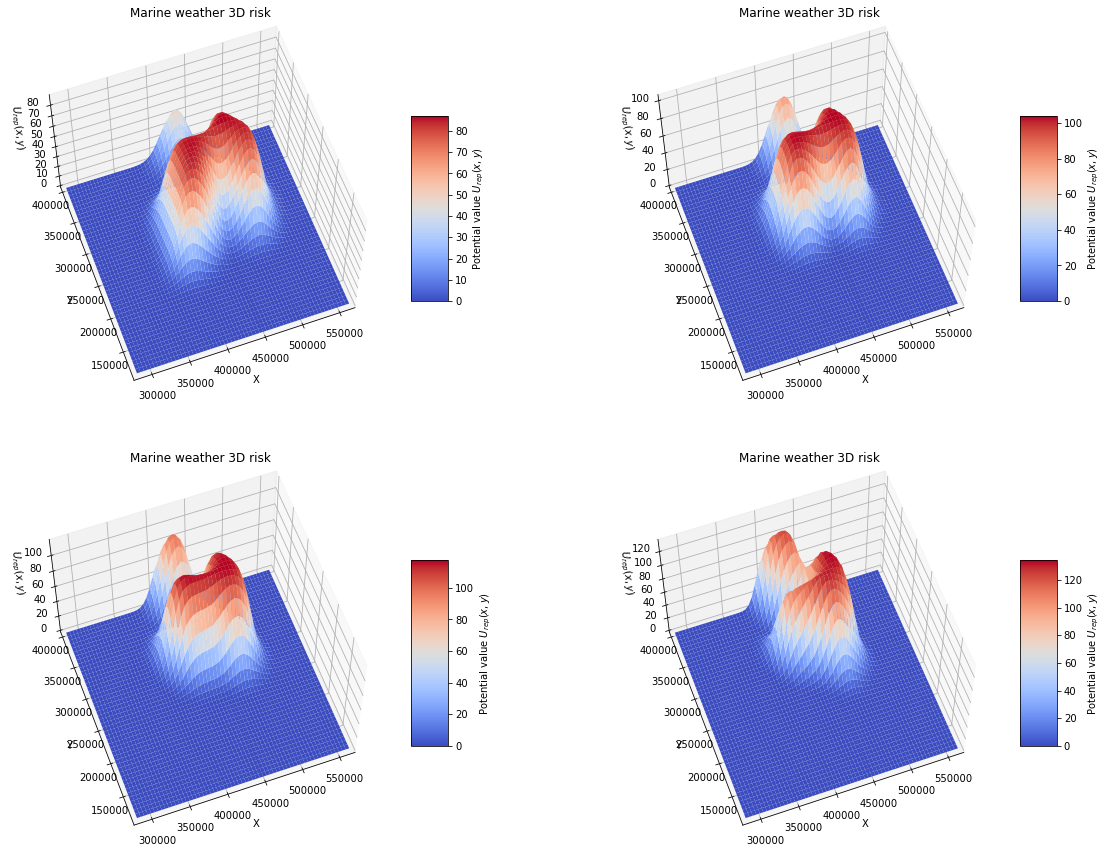

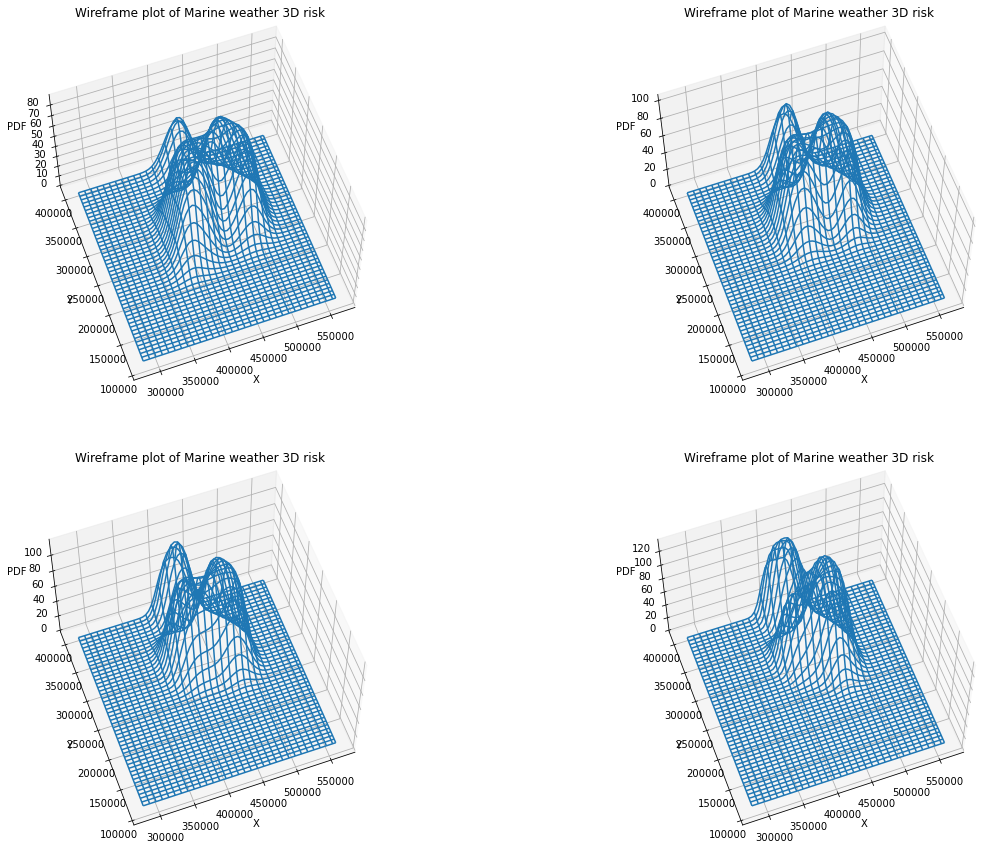

In [51]:
u_rep = np.zeros_like(f2)
for i in range(l):  
    u_rep[i] = f_tot[i]*10e11

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax.plot_surface(xs_, ys_, u_rep[0], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(xs_, ys_, u_rep[1], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 3, projection='3d')
surf = ax.plot_surface(xs_, ys_, u_rep[2], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 4, projection='3d')
surf = ax.plot_surface(xs_, ys_, u_rep[3], rstride=1, cstride=1, cmap='coolwarm')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plt.colorbar(surf, shrink=0.5, aspect=5, label='Potential value $U_{rep}(x,y)$') # add color bar indicating the PDF
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('$U_{rep}(x,y)$')
ax.set_title('Marine weather 3D risk')
plt.show()

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(2, 2, 1, projection='3d')
w = ax.plot_wireframe(xs_, ys_, u_rep[0])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 2, projection='3d')
w = ax.plot_wireframe(xs_, ys_, u_rep[1])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 3, projection='3d')
w = ax.plot_wireframe(xs_, ys_, u_rep[2])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')

ax = fig.add_subplot(2, 2, 4, projection='3d')
w = ax.plot_wireframe(xs_, ys_, u_rep[3])
ax.view_init(60, -110)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Marine weather 3D risk')
plt.show()

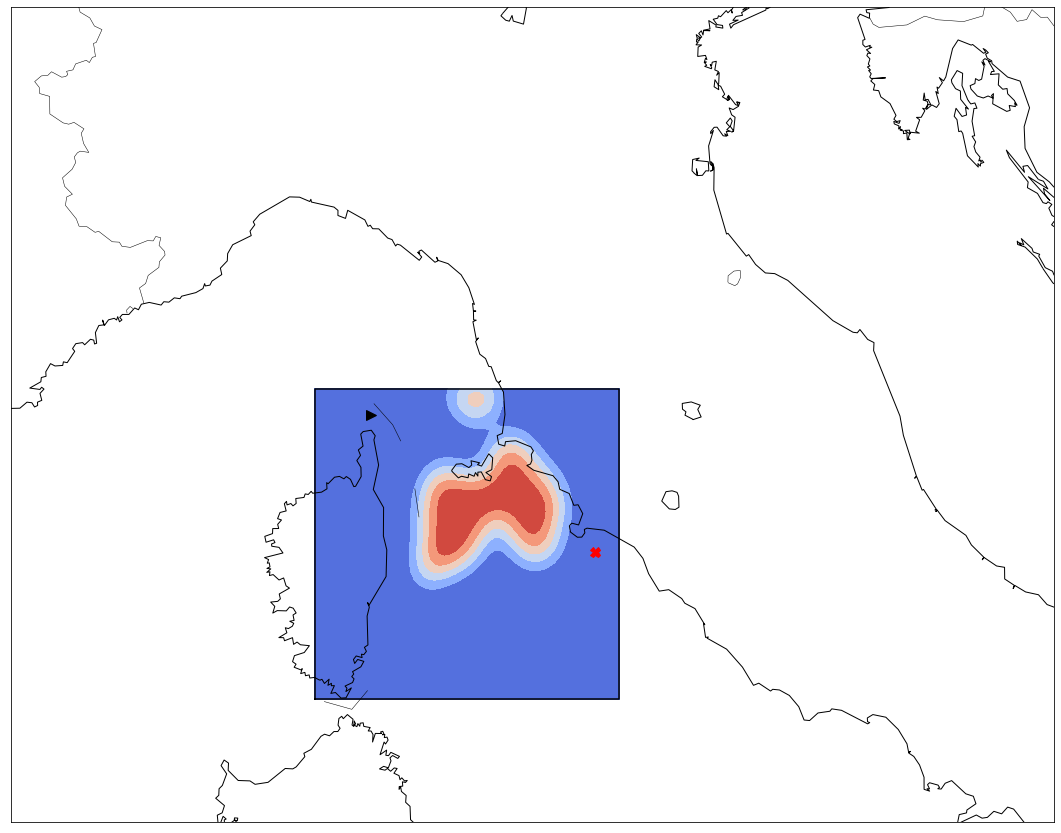

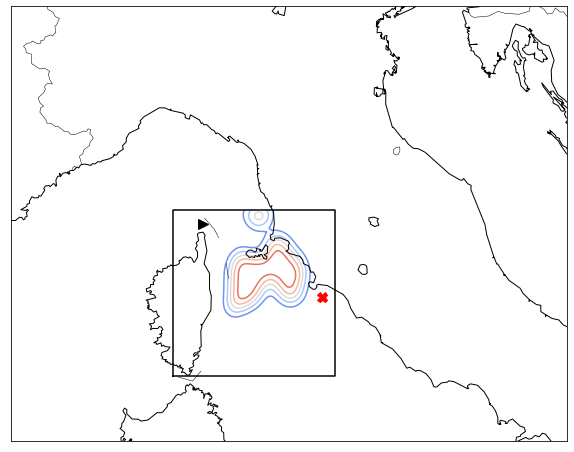

In [52]:
plt.figure(1, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')
ax3 = plt.axes()
ax3.contourf(xs_, ys_, u_rep[0], cmap='coolwarm')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
#plt.plot(x_obsl_, y_obsl_, '.', color="sienna")
#plt.plot(x_obsm_[0], y_obsm_[0], ".", color='dodgerblue')
#cset = plt.contour(xs_, ys_, f_tot[0], colors='k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

plt.figure(2, figsize=(10, 8))
ax2 = plt.axes()
ax2.contour(xs_, ys_, u_rep[0], cmap='coolwarm')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [53]:
k_rep_c = 10e9
ox = x_obsl_
oy = y_obsl_
goal = (gx, gy)
pot_map2 = [[[0.0 for k in range(len(xslice))] for j in range(len(yslice))] for i in range(l)]

# repulsive potential field for coastlines
for i in range(l):
    for ix in range(len(xslice)):
        for iy in range(len(yslice)):
            minid = -1
            dmin = float("inf")
            for k, _ in enumerate(ox):
                d = np.hypot(xs_[iy][ix] - ox[k], ys_[iy][ix] - oy[k])
                if dmin >= d:
                    dmin = d
                    minid = k
            dq = np.hypot(xs_[iy][ix] - ox[minid], ys_[iy][ix] - oy[minid])
            if dq <= 10000:
                if dq <= 5000:
                    dq = 5000
                pot_map2[i][iy][ix] = 0.5 * k_rep_c * (1.0 / dq - 1.0 / 10000) ** 2
            else:
                pot_map2[i][iy][ix] = 0

repulsive_map = pot_map2 + u_rep

<ipython-input-54-d94f6c6172ec>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  scheme = mp.pcolor(xs_, ys_, repulsive_map[0], cmap=cm.YlOrBr)
<ipython-input-54-d94f6c6172ec>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  scheme = mp.pcolor(xs_, ys_, repulsive_map[1], cmap=cm.YlOrBr)
<ipython-input-54-d94f6c6172ec>:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corn

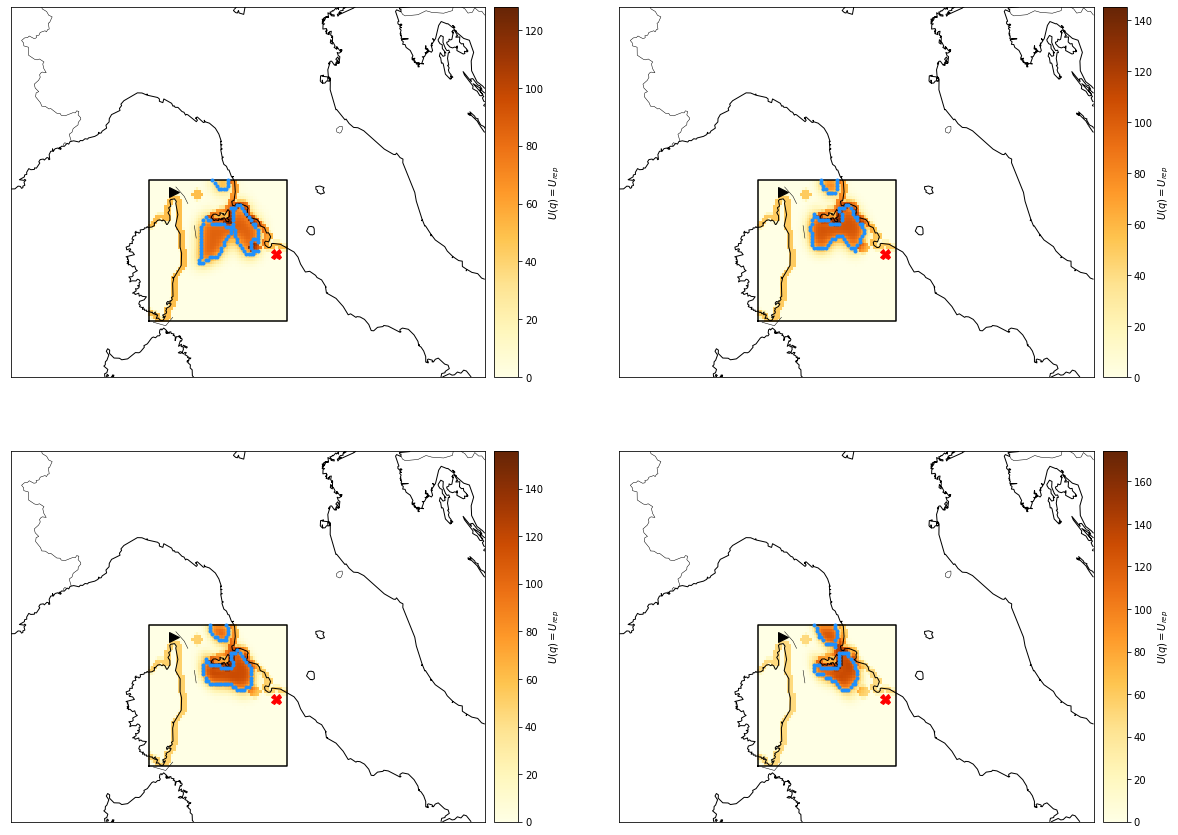

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[0][0])
scheme = mp.pcolor(xs_, ys_, repulsive_map[0], cmap=cm.YlOrBr)
c_bar = mp.colorbar(scheme)
mp.plot(sx, sy, ">k", markersize=10)
mp.plot(gx, gy, "Xr", markersize=10)
c_bar.set_label('$U(q)=U_{rep}$')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(x_obsm_[0], y_obsm_[0], ".", color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[0][1])
scheme = mp.pcolor(xs_, ys_, repulsive_map[1], cmap=cm.YlOrBr)
c_bar = mp.colorbar(scheme)
mp.plot(sx, sy, ">k", markersize=10)
mp.plot(gx, gy, "Xr", markersize=10)
c_bar.set_label('$U(q)=U_{rep}$')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(x_obsm_[1], y_obsm_[1], ".", color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][0])
scheme = mp.pcolor(xs_, ys_, repulsive_map[2], cmap=cm.YlOrBr)
c_bar = mp.colorbar(scheme)
mp.plot(sx, sy, ">k", markersize=10)
mp.plot(gx, gy, "Xr", markersize=10)
c_bar.set_label('$U(q)=U_{rep}$')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(x_obsm_[2], y_obsm_[2], ".", color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()

mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i', ax=ax[1][1])
scheme = mp.pcolor(xs_, ys_, repulsive_map[3], cmap=cm.YlOrBr)
c_bar = mp.colorbar(scheme)
mp.plot(sx, sy, ">k", markersize=10)
mp.plot(gx, gy, "Xr", markersize=10)
c_bar.set_label('$U(q)=U_{rep}$')
mp.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.plot(x_obsm_[3], y_obsm_[3], ".", color="dodgerblue")
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

In [55]:
# attractive potential field
q_g = 50000
k_att = 1
goal = (gx, gy)
att_pot_map = [[[0.0 for i in range(len(xslice))] for j in range(len(yslice))] for i in range(l)]
for i in range(l):
    for ix in range(len(xslice)):
        for iy in range(len(yslice)):
            d_g = np.sqrt((xs_[iy][ix] - goal[0]) ** 2 + (ys_[iy][ix] - goal[1]) ** 2)
            if d_g <= 2000:
                d_g = 2000
            if d_g <= q_g:
                u_att = 0.5 * k_att * d_g ** 2
            else:
                u_att = q_g * k_att * d_g - 0.5 * k_att * q_g ** 2
            att_pot_map[i][iy][ix] = u_att/100000000
plot_map = np.array(att_pot_map) + repulsive_map

<ipython-input-56-fcd5c8156c4d>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(xs_, ys_, plot_map[0], cmap=cm.YlOrBr)


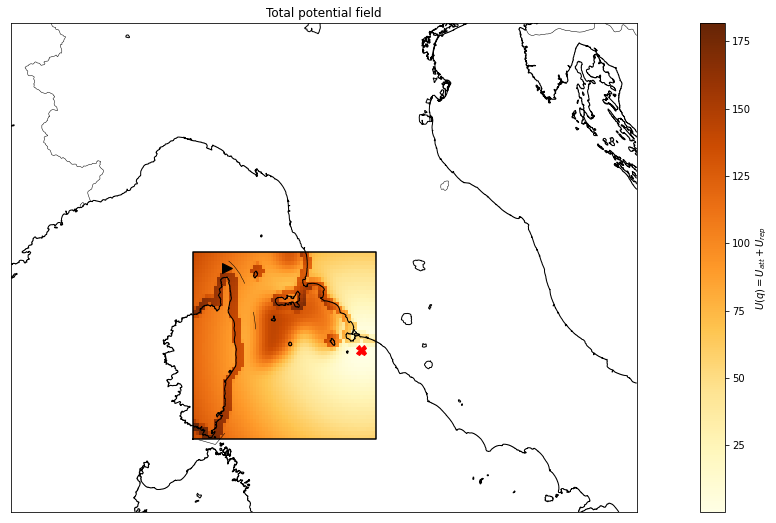

In [56]:
fig1 = plt.figure(1, figsize=(15, 9))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='f')
plt.pcolor(xs_, ys_, plot_map[0], cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")

mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Total potential field')
#plt.savefig('tot_pot.png', dpi=300)
plt.show()

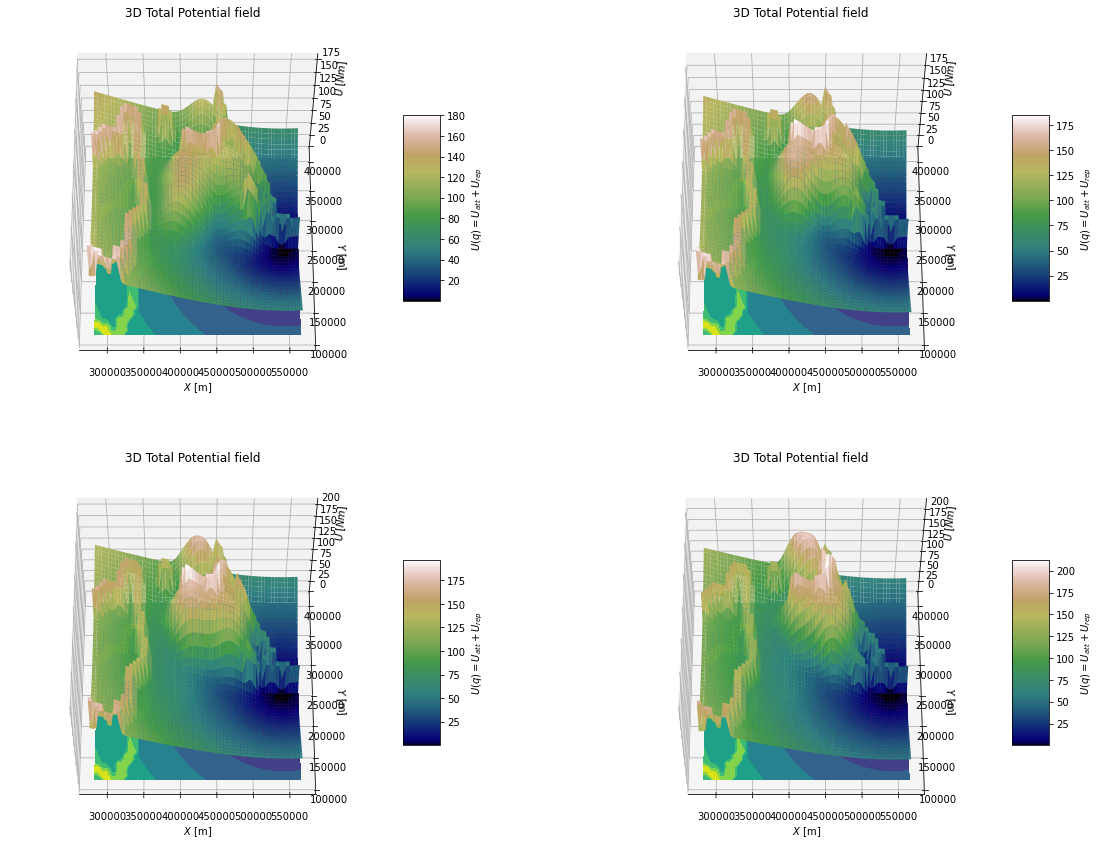

In [57]:
fig = plt.figure(2, figsize=(20, 15))

ax = fig.add_subplot(2, 2, 1, projection='3d')
surf = ax.plot_surface(xs_, ys_, plot_map[0], rstride=1, cstride=1, cmap='gist_earth')
plt.colorbar(surf, shrink=0.5, aspect=5, label= '$U(q)=U_{att}+U_{rep}$')
ax.set_xlabel("$X$ [m]")
ax.set_ylabel("$Y$ [m]")
ax.set_zlabel("$U$ [$Nm$]")
ax.plot(sx, sy, ">k", markersize=10)
ax.plot(gx, gy, "Xr", markersize=10)
ax.title.set_text('3D Total Potential field')
ax.contourf(xs_, ys_, plot_map[0], zdir='z', offset=0)
ax.view_init(60, -90)

ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(xs_, ys_, plot_map[1], rstride=1, cstride=1, cmap='gist_earth')
plt.colorbar(surf, shrink=0.5, aspect=5, label= '$U(q)=U_{att}+U_{rep}$')
ax.set_xlabel("$X$ [m]")
ax.set_ylabel("$Y$ [m]")
ax.set_zlabel("$U$ [$Nm$]")
ax.plot(sx, sy, ">k", markersize=10)
ax.plot(gx, gy, "Xr", markersize=10)
ax.title.set_text('3D Total Potential field')
ax.contourf(xs_, ys_, plot_map[0], zdir='z', offset=0)
ax.view_init(60, -90)

ax = fig.add_subplot(2, 2, 3, projection='3d')
surf = ax.plot_surface(xs_, ys_, plot_map[2], rstride=1, cstride=1, cmap='gist_earth')
plt.colorbar(surf, shrink=0.5, aspect=5, label= '$U(q)=U_{att}+U_{rep}$')
ax.set_xlabel("$X$ [m]")
ax.set_ylabel("$Y$ [m]")
ax.set_zlabel("$U$ [$Nm$]")
ax.plot(sx, sy, ">k", markersize=10)
ax.plot(gx, gy, "Xr", markersize=10)
ax.title.set_text('3D Total Potential field')
ax.contourf(xs_, ys_, plot_map[0], zdir='z', offset=0)
ax.view_init(60, -90)

ax = fig.add_subplot(2, 2, 4, projection='3d')
surf = ax.plot_surface(xs_, ys_, plot_map[3], rstride=1, cstride=1, cmap='gist_earth')
plt.colorbar(surf, shrink=0.5, aspect=5, label= '$U(q)=U_{att}+U_{rep}$')
ax.set_xlabel("$X$ [m]")
ax.set_ylabel("$Y$ [m]")
ax.set_zlabel("$U$ [$Nm$]")
ax.plot(sx, sy, ">k", markersize=10)
ax.plot(gx, gy, "Xr", markersize=10)
ax.title.set_text('3D Total Potential field')
ax.contourf(xs_, ys_, plot_map[0], zdir='z', offset=0)
ax.view_init(60, -90)
plt.show()

In [50]:
# APF shin sui
# start = (sx, sy)
# goal = (gx, gy)
# obs = []
# k_att = 1
# k_rep = 10e15
# rr = 10000
# for i in range(len(x_obstot_)):
#     obs.append([x_obstot_[i], y_obstot_[i]])
    
# step_size, iter_max, goal_threshold = 3000, 1000, 5000
# step_size_ = 6000

# apf = APF(start, goal, obs, q_g, k_att, k_rep, rr, step_size, iter_max, goal_threshold)
# apf.path_plan()

In [61]:
# path = apf.path
# path_ = []
# i = int(step_size_ / step_size)  # 2/0.2 = 10
# while i < len(path):
#     path_.append(path[i])  # add a sample every 10
#     i += int(step_size_ / step_size)
# if path_[-1] != path[-1]:
#     path_.append(path[-1])
# #print('Way-points:{}'.format(path_))
# if apf.is_path_plan_success:
#     print('Path plan SUCCESS! :)')
# else:
#     print('Path plan FAILED :(')

Path plan FAILED :(


In [51]:
# px, py = [K[0] for K in path_], [K[1] for K in path_]
# fig1 = plt.figure(1, figsize=(20, 15))
# ax = fig1.add_subplot()
# plt.pcolor(xs_, ys_, plot_map, cmap=cm.YlOrBr)
# c_bar = plt.colorbar()
# c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
# plt.plot(sx, sy, ">k", markersize=10)
# plt.plot(gx, gy, "Xr", markersize=10)
# plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
# plt.plot(px, py, '.k')
# mp.drawcoastlines()
# mp.drawstates()
# mp.drawcountries()
# plt.title('Potential field algorithm')
# ax.set_aspect('equal', adjustable='box')
# plt.show()

In [58]:
start = (sx, sy)
goal = (gx, gy)
robot_radius = 10000
ox = x_obsm_[0]
oy = y_obsm_[0]
xw = 62
yw = 47
ux = np.linspace(x_min, x_max, xw)
uy = np.linspace(y_min, y_max, yw)
uxs, uys = np.meshgrid(ux, uy)
f = [[] for i in range(l)]
for i in range(l):
    positions = np.vstack([uxs.ravel(), uys.ravel()])
    values = np.vstack([oxmeteo_[i]+x_obsm_[i], oymeteo_[i]+y_obsm_[i]])
    kernel = st.gaussian_kde(values)
    f[i] = np.reshape(kernel(positions).T, uxs.shape)

f_tot = np.zeros_like(f)
for i in range(l):  
    f_tot[i] = f[i]*10e11

#def calc_gaussian_pot():
    
def comb_attractive_potential(x, y, gp, q_g):
    d_g = np.sqrt((x - gp[0]) ** 2 + (y - gp[1]) ** 2)
    if d_g <= 2000:
        d_g = 2000
    if d_g <= q_g:
        att_pot = 0.5 * k_att * d_g ** 2
    else:
        att_pot = q_g * k_att * d_g - 0.5 * k_att * q_g ** 2
    return att_pot

def calc_repulsive_potential(x, y, ox, oy, rr):
    k_rep_c = 10e9
    # search nearest obstacle
    minid = -1
    dmin = float("inf")
    for i, _ in enumerate(ox):
        d = np.hypot(x - ox[i], y - oy[i])
        if dmin >= d:
            dmin = d
            minid = i

    # calc repulsive potential
    dq = np.hypot(x - ox[minid], y - oy[minid])

    if dq <= rr:
        if dq <= 2000:
            dq = 2000

        return 0.5 * k_rep_c * (1.0 / dq - 1.0 / rr) ** 2
    else:
        return 0.0
    
grid_size1 = 4558
grid_size2 = 6133
xw = round((x_max - x_min) / grid_size1)
yw = round((y_max - y_min) / grid_size2)
print("x_width:", xw)
print("y_width:", yw)
# calc each potential
pmap = [[[0.0 for i in range(xw)] for i in range(yw)] for i in range(l)]
for i in range(l):
    for ix in range(xw):
        x = ix * grid_size1 + x_min
        for iy in range(yw):
            y = iy * grid_size2 + y_min
            ug = comb_attractive_potential(x, y, goal, q_g)/5e7
            uo = calc_repulsive_potential(x, y, ox, oy, robot_radius)
            uo_land = calc_repulsive_potential(x, y, x_obsl_, y_obsl_, robot_radius)/10
            uf = ug
            pmap[i][iy][ix] = uf + uo_land
plot_map1 = f_tot + np.array(pmap)

x_width: 62
y_width: 47


<ipython-input-59-1f6c8027ea2b>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(uxs, uys, plot_map1[0], cmap=cm.YlOrBr)


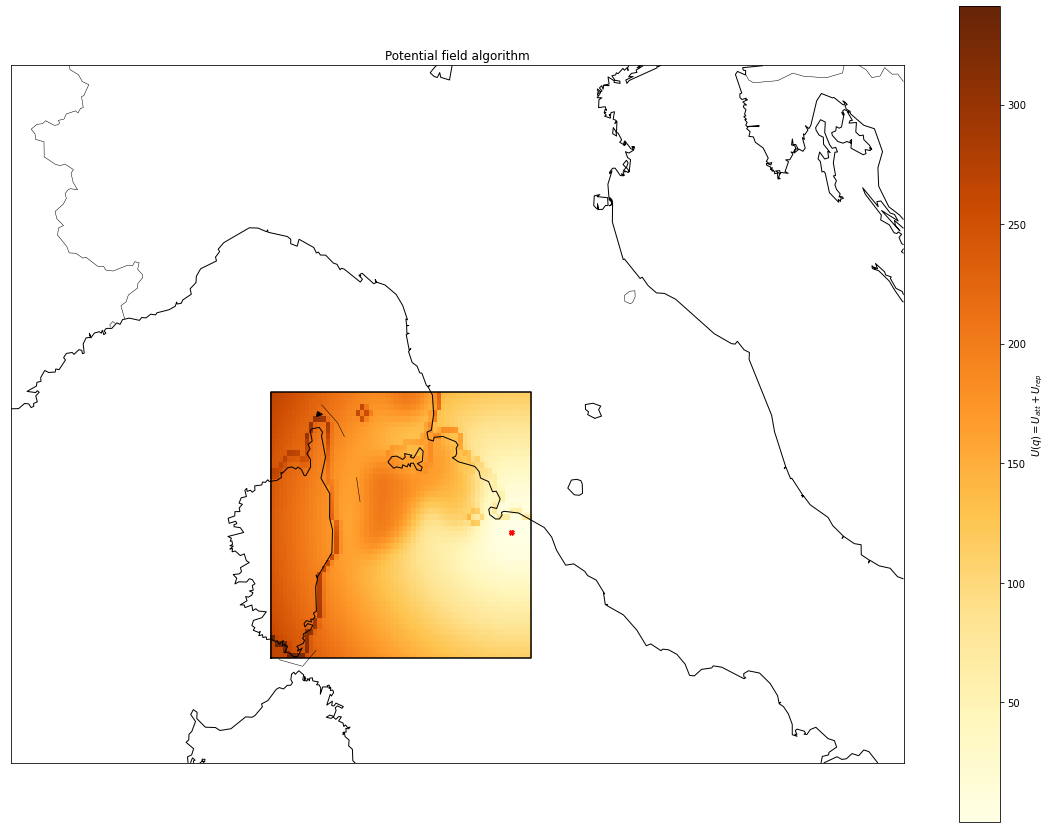

In [59]:
fig1 = plt.figure(1, figsize=(20, 15))
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  # 4.125, 10,  # -5.42,
             llcrnrlat=40.58,  # 33.1875, 42
             urcrnrlon=15.13,  # 20.291667938, 12
             urcrnrlat=45.5488,  # 45.97916,  42.7488
             resolution='i')
ax = fig1.add_subplot()
plt.pcolor(uxs, uys, plot_map1[0], cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx, sy, ">k", markersize=5)
plt.plot(gx, gy, "Xr", markersize=5)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
#plt.plot(path_x, path_y, '.k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [60]:
# KP = 5.0  # attractive potential gain
# ETA = 100.0  # repulsive potential gain
OSCILLATIONS_DETECTION_LENGTH = 5
show_animation = True

def get_motion_model():
    # dx, dy
    motion = [[1, 0],
              [0, 1],
              [-1, 0],
              [0, -1],
              [-1, -1],
              [-1, 1],
              [1, -1],
              [1, 1]]

    return motion


def oscillations_detection(previous_ids, ix, iy):
    previous_ids.append((ix, iy))

    if (len(previous_ids) > OSCILLATIONS_DETECTION_LENGTH):
        previous_ids.popleft()

    # check if contains any duplicates by copying into a set
    previous_ids_set = set()
    for index in previous_ids:
        if index in previous_ids_set:
            return True
        else:
            previous_ids_set.add(index)
    return False

def rep_potential_detect(os_lim, g, ox, oy, os_r, plot_map, xm, ym, gs1, gs2):
    k_rep_c = 2e8
    for ix in range(62):
        x = ix * gs1 + xm
        for iy in range(47):
            y = iy * gs2 + ym
            dq = np.hypot(x - ox, y - oy)  # distance from the nearest obstacle
            dg = np.hypot(x - g[0], y - g[1])
            if dq <= os_r:
                if dq <= os_lim:
                    dq = os_lim
                plot_map[iy][ix] += 0.5 * k_rep_c * (1 / dq - 1 / os_r) ** 2
            else:
                plot_map[iy][ix] += 0
    return plot_map

def calc_dist_from_start(x, y, start):
    a1 = mp(start[0], start[1], inverse=True)
    b1 = mp(x, y, inverse=True)
    return geopy.distance.distance(a1, b1).m

def potential_field_planning(s, g, reso1, reso2, rr, plot_map, xm, ym, distance, k, xmax, ymax, uxs, uys):
    d = np.hypot(s[0] - g[0], s[1] - g[1])
    ix = round((s[0] - xm) / reso1)
    iy = round((s[1] - ym) / reso2)
    gix = round((g[0] - xm) / reso1)
    giy = round((g[0] - ym) / reso2)

    if show_animation:
        draw_heatmap(plot_map[k-1], uxs, uys)
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                lambda event: [exit(0) if event.key == 'escape' else None])
        plt.plot(s[0], s[1], ">k", markersize=5)
        plt.plot(g[0], g[1], "Xr", markersize=5)
        plt.plot([xm, xmax, xmax, xm, xm], [ym, ym, ymax, ymax, ym], "-k")
        mp.drawcoastlines()
        mp.drawstates()
        mp.drawcountries()
        plt.title('Potential field algorithm')
    
    rx, ry = [s[0]], [s[1]]
    motion = get_motion_model()
    previous_ids = deque()

    while d >= 6000:
        minp = float("inf")
        minix, miniy = -1, -1
        for i, _ in enumerate(motion):
            inx = int(ix + motion[i][0])
            iny = int(iy + motion[i][1])
            if iny >= len(plot_map[k-1]) or inx >= len(plot_map[k-1][0]) or inx < 0 or iny < 0:
                p = float("inf")  # outside area
                #print("outside potential!")
            else:
                p = plot_map[k-1][iny][inx]
            if minp > p:
                minp = p
                minix = inx
                miniy = iny
        ix = minix
        iy = miniy
        xp = ix * reso1 + xm
        yp = iy * reso2 + ym
        d = np.hypot(g[0] - xp, g[1] - yp)
        rx.append(xp)
        ry.append(yp)

        if (oscillations_detection(previous_ids, ix, iy)):
            print("Oscillation detected at ({},{})!".format(ix, iy))
            plot_map[k-1] = rep_potential_detect(2000, g, ix*reso1+xm, iy*reso2+ym, 10000, plot_map[k-1], xm, ym, reso1, reso2)
            print(ix*reso1+xm, iy*reso2+ym)
            k = 1
            break

        if show_animation:
            plt.plot(ix*reso1+xm, iy*reso2+ym, ".r")
            plt.pause(0.1)
            
        distance = calc_dist_from_start(xp, yp, s)
        if distance/2 >= 10000*k:
            k += 1
            if k > 4:
                k = 4
            draw_heatmap(plot_map[k-1], uxs, uys)

    if d < 6000:
        print("The robot is arrived at the final point!")
#     else:
#         print("The robot got lost!"
    return rx, ry, plot_map, d, distance


def draw_heatmap(data, x, y):
    
    data = np.array(data)
    plt.pcolor(x, y, data, cmap=plt.cm.YlOrBr)


In [61]:
# %matplotlib inline
plot_map_test = plot_map1
import time
dist_tot = 0
k = 1
start_time = time.time()
while d >= 6000: 
    path_x, path_y, pot_map_sim, d_update, new_distance = potential_field_planning(start, goal, grid_size1, grid_size2, robot_radius, plot_map_test, x_min, y_min, dist_tot, k, x_max, y_max, uxs, uys)
    plot_map_test = pot_map_sim
    d = d_update
print("Computational time is {}".format(time.time() - start_time))

Using matplotlib backend: Qt5Agg


<ipython-input-60-b73dcbd95902>:131: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, data, cmap=plt.cm.YlOrBr)


The robot is arrived at the final point!
Computational time is 13.655579566955566


In [126]:
d = np.hypot(start[0] - goal[0], start[1] - goal[1])
d
del new_distance
del path_x, path_y

<ipython-input-68-9f3a15f0fc12>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(xs_, ys_, plot_map1[0], cmap=cm.YlOrBr)


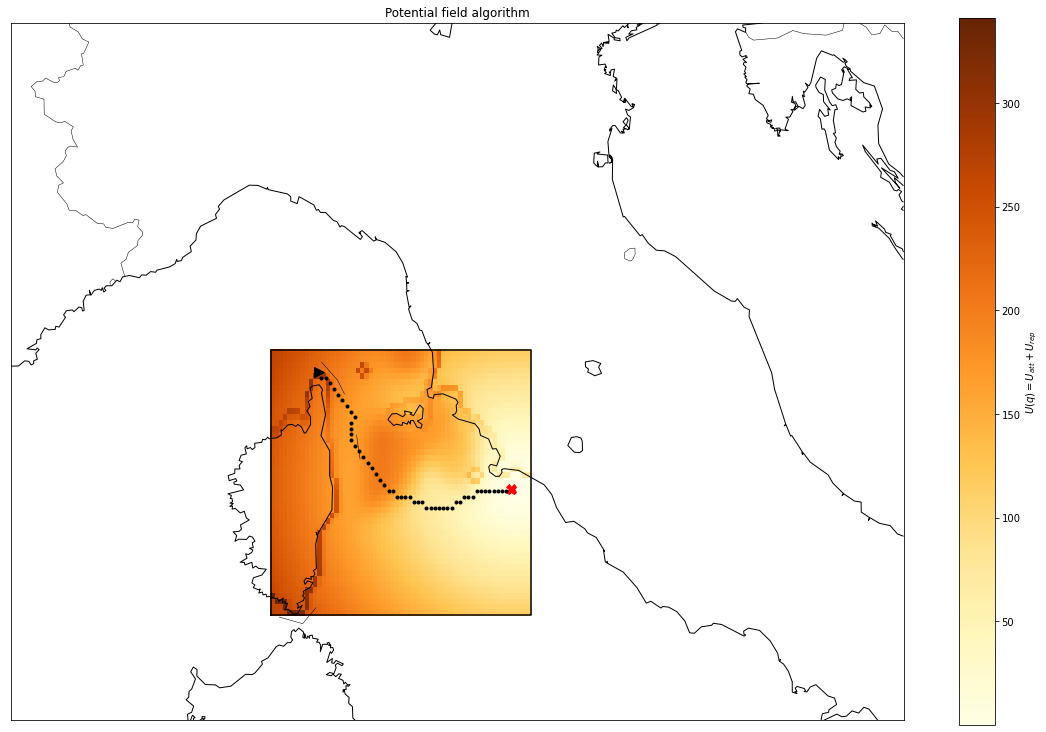

In [68]:
fig1 = plt.figure(1, figsize=(20, 13))
ax = fig1.add_subplot()
plt.pcolor(xs_, ys_, plot_map1[0], cmap=cm.YlOrBr)
c_bar = plt.colorbar()
c_bar.set_label('$U(q)=U_{att}+U_{rep}$')
plt.plot(sx, sy, ">k", markersize=10)
plt.plot(gx, gy, "Xr", markersize=10)
plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.plot(path_x, path_y, '.k')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.title('Potential field algorithm')
ax.set_aspect('equal', adjustable='box')
plt.savefig('apf.png', dpi=300)
plt.show()